In [8]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
df_test = pd.read_csv("./training_data/merged_train_i2.csv", sep=';')

not_chosen_columns = ['ID', 'Tweet']
label_columns = [col for col in df_test.columns if col not in not_chosen_columns]

df_labels_test = df_test[label_columns]

list_labels_test = df_labels_test.values.tolist()

test_texts = df_test['Tweet'].tolist()
test_labels = list_labels_test

tokenizer = BertTokenizer.from_pretrained("saved_model_try_6_i2")
model = BertForSequenceClassification.from_pretrained("saved_model_try_6_i2")

In [10]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_probabilities = []

# Process each text
for text in test_texts:
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities
    probabilities = probabilities.squeeze(0)

    all_probabilities.append(probabilities) #Değiştir

In [11]:
all_probabilities_l = []

for item in all_probabilities:
    all_probabilities_l.append(item.tolist())

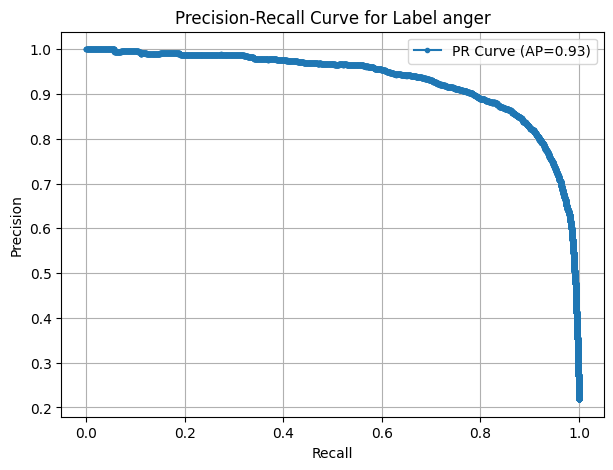

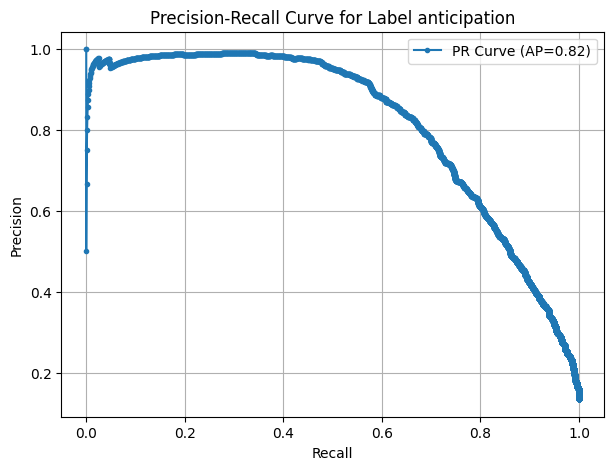

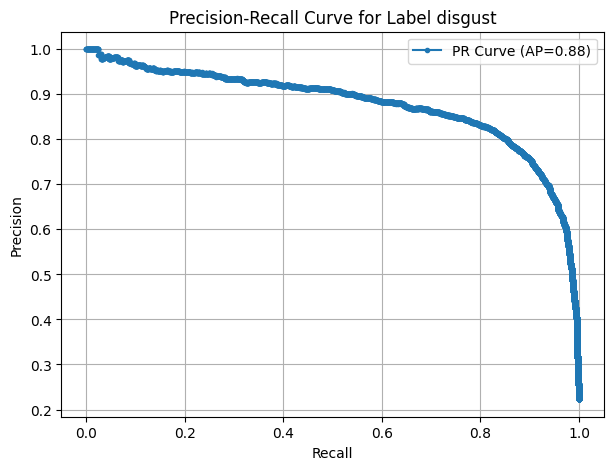

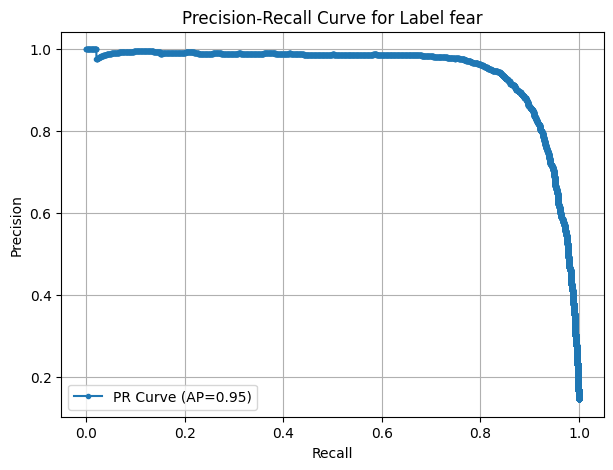

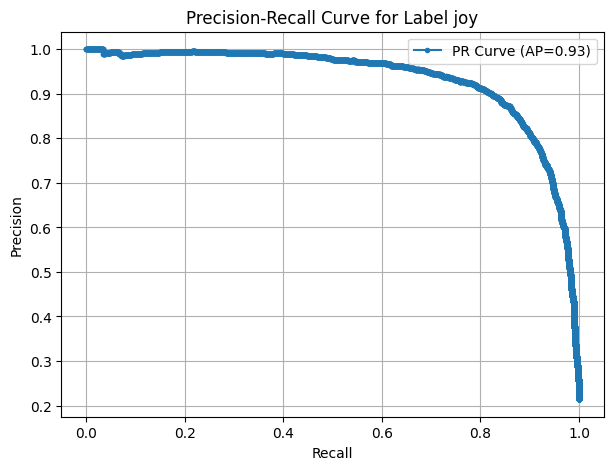

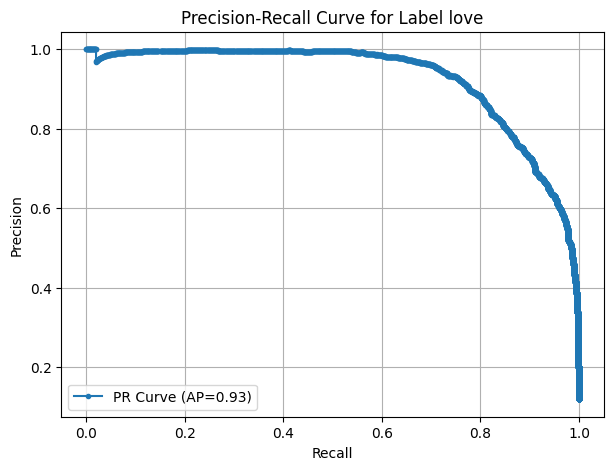

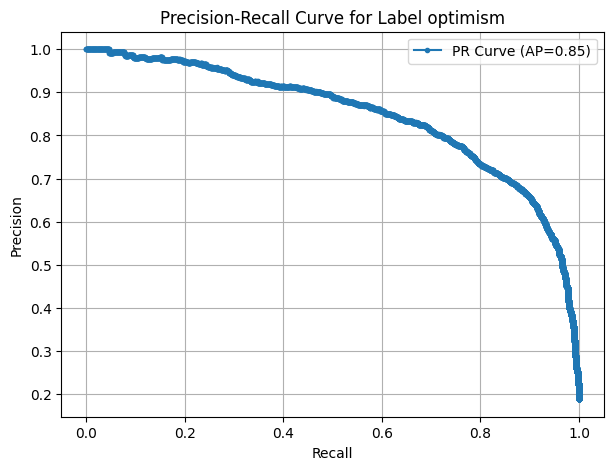

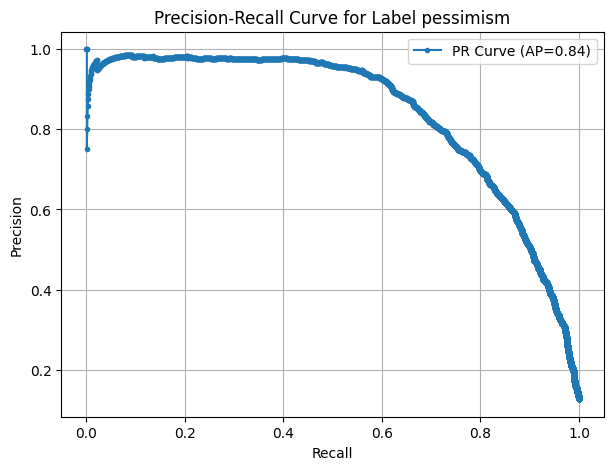

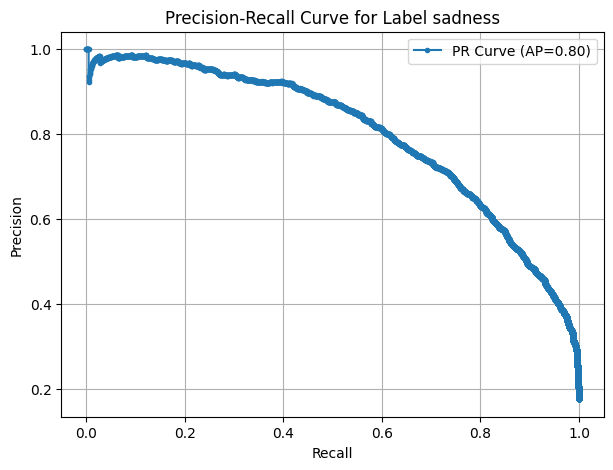

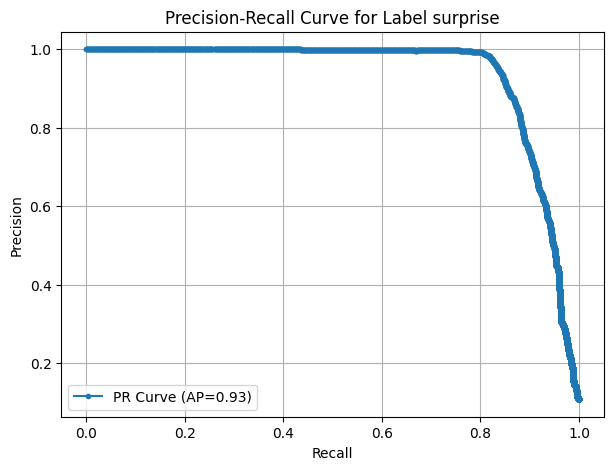

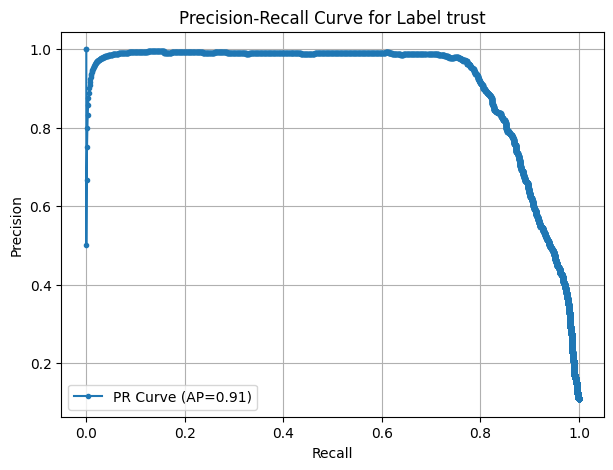

[0.41, 0.35, 0.4, 0.47, 0.43, 0.53, 0.52, 0.53, 0.4, 0.52, 0.6]


,0,1,2,3,4,5,6,7,8,9,10
0,0.034227,0.153988,0.025630,0.194217,0.424585,0.063314,0.936642,0.028981,0.045063,0.032240,0.707325
1,0.032525,0.119166,0.028489,0.039085,0.907168,0.461938,0.921120,0.022211,0.048964,0.043159,0.268592
2,0.124383,0.322036,0.158380,0.044826,0.901965,0.051065,0.502018,0.039595,0.211484,0.403876,0.034786
3,0.035913,0.182848,0.024886,0.066140,0.876544,0.185515,0.940671,0.025755,0.051708,0.043852,0.334400
4,0.921532,0.046797,0.919591,0.243898,0.028799,0.015313,0.019452,0.129855,0.472046,0.033121,0.016523
...,...,...,...,...,...,...,...,...,...,...,...
12647,0.028713,0.058847,0.033092,0.030287,0.035329,0.024953,0.019051,0.052411,0.027499,0.939132,0.040534
12648,0.017502,0.021143,0.024342,0.017617,0.172463,0.913500,0.063962,0.025396,0.021339,0.031609,0.043814
12649,0.022603,0.055755,0.030516,0.915400,0.020158,0.019897,0.026623,0.059075,0.032646,0.063848,0.041927
12650,0.064741,0.044385,0.086453,0.949265,0.017536,0.020012,0.023269,0.084695,0.074850,0.036221,0.029898


In [12]:
#Precision-Recall curve 

from sklearn.metrics import precision_recall_curve, average_precision_score

def optimize_threshold_pr(y_true, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # Avoid division by zero
    best_threshold = thresholds[np.argmax(f1_scores)]

    return best_threshold

all_probabilities_pd = pd.DataFrame(all_probabilities_l)
test_labels_pd = pd.DataFrame(test_labels)

found_thres = []

for i in range( all_probabilities_pd.shape[1] ):

    col_prob = all_probabilities_pd.iloc[:,i]
    col_prob= torch.tensor(col_prob)

    col_true = test_labels_pd.iloc[:,i]
    col_true= torch.tensor(col_true)

    best_thresh = optimize_threshold_pr(col_true, col_prob)

    precisions, recalls, thresholds = precision_recall_curve(col_true, col_prob)
    ap_score = average_precision_score(col_true, col_prob)

    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

    plt.figure(figsize=(7, 5))
    plt.plot(recalls, precisions, marker=".", label=f"PR Curve (AP={ap_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for Label {emotions[i]}")
    plt.legend()
    plt.grid()
    plt.show()
    
    found_thres.append(round(best_thresh, 2))

print(found_thres)

all_probabilities_pd